In [1]:
# @title Install necessary libraries
import os
import multiprocessing
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    max(multiprocessing.cpu_count(), 1)
)
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

try:
    import rexv2
    print("Rex already installed")
except ImportError as e:
    print("Please install rex via `pip install rex-lib[paper]`. Tested with rex-lib==0.0.3")
    raise e
    !pip install rex-lib[paper]

Rex already installed


In [2]:
# @title Import libraries & check GPU availability
from IPython.display import HTML
import functools
import jax
import itertools
import tqdm
import jax.numpy as jnp
import equinox as eqx
import numpy as onp
from distrax import Deterministic, Normal
import supergraph
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import rexv2.utils as rutils
import rexv2.base as base
from rexv2.open_colors import ecolor, fcolor
from rexv2.constants import RealTimeFactor, Clock
from rexv2.base import StaticDist, TrainableDist

# Check if we have a GPU
try:
    gpu = jax.devices("gpu")
    gpu = gpu[0] if len(gpu) > 0 else None
    print("GPU found!")
except RuntimeError:
    print("Warning: No GPU found, falling back to CPU. Speedups will be less pronounced.")
    print("Hint: if you are using Google Colab, try to change the runtime to GPU: "
          "Runtime -> Change runtime type -> Hardware accelerator -> GPU.")
    gpu = None

# Check the number of available CPU cores
print(f"CPU cores available: {len(jax.devices('cpu'))}")
cpus = itertools.cycle(jax.devices("cpu"))

GPU found!
CPU cores available: 16


In [3]:
# @title Define pendulum system as interconnection of nodes
# @markdown We will first use the nodes defined in the pendulum example to define the simulated system
# @markdown We do not have a real-world system, so we will act as if the pendulum simulated with brax is the real-world system
# @markdown We will collect some data from the brax system and use it to identify the delays and parameters of a simple ODE model
# @markdown In another notebook example, we will show how to define nodes.
# Import the nodes from the pendulum example (see other notebook examples on how to define nodes)
from rexv2.pendulum.nodes import Sensor, Agent, Actuator, BraxWorld

# `Color` and `order` arguments are merely for visualization purposes.
# Delay distributions are used to simulate the delays as if the nodes were real-world systems.
# For real-world systems, it is normally not necessary to specify the delay distributions.
sensor = Sensor(name="sensor", rate=50, color="pink", order=1,  # Sensor that reads the angle from the pendulum
                delay_dist=Normal(loc=0.0075, scale=0.003))  # Computation delay of the sensor
agent = Agent(name="agent", rate=50, color="teal", order=3,  # Agent that generates random actions
              delay_dist=Normal(loc=0.01, scale=0.003))  # Computation delay of the agent
actuator = Actuator(name="actuator", rate=50, color="orange", order=2,  # Actuator that applies the action to the pendulum
                    delay_dist=Normal(loc=0.0075, scale=0.003))  # Computation delay of the actuator
world = BraxWorld(name="world", rate=50, color="grape", order=0,  # Brax world that simulates the pendulum
                  # Computation delay of the world is the world's step size
                  delay_dist=Deterministic(loc=0.99/50))  # 0.99 to ensure it's slightly less than the world's step size (numerical stability)
nodes = dict(world=world, sensor=sensor, agent=agent, actuator=actuator)

# Connect nodes
# The window determine the buffer size, i.e., the number of previous messages that are stored and can be accessed
# in the .step() method of the node. The window should be at least 1, as the most recent message is always stored.
# Blocking connections are synchronous, i.e., the receiving node waits for the sending node to send a message.
# The window determines the number of messages that are stored and can be accessed in the .step() method of the node.
agent.connect(sensor, window=3, name="sensor", blocking=True,  # Use the last three sensor messages as input (sync communication)
              delay_dist=Normal(loc=0.002, scale=0.002))  # Communication delay of the sensor
actuator.connect(agent, window=1, name="agent", blocking=True,  # Agent receives the most recent action (sync communication)
                 delay_dist=Normal(loc=0.002, scale=0.002))  # Communication delay of the agent

# Connections below would not be necessary in a real-world system,
# but are used to communicate the action to brax, and convert brax's state to a sensor message
# Delay distributions are used to simulate the delays in the real-world system
sensor_delay, actuator_delay = 0.01, 0.01
std_delay = 0.002
world.connect(actuator, window=1, name="actuator", skip=True,  # Sends the action to the brax world (skip=True to resolve circular dependency)
              delay_dist=Normal(loc=actuator_delay, scale=std_delay))  # Actuator delay between applying the action, and the action being effective in the world
sensor.connect(world, window=1, name="world",  # Communicate brax's state to the sensor node
               delay_dist=Normal(loc=sensor_delay, scale=std_delay))  # Sensor delay between reading the state, and the world's state corresponding to the sensor reading.

# If you want to test with zero delays, uncomment below.
# sensor_delay, actuator_delay = 0.0, 0.0
# std_delay = 0.0
# for n in [sensor, agent, actuator]:
#     n.set_delay(delay_dist=Deterministic(loc=0.0), delay=0.0)
#     for i in n.inputs.values():
#         i.set_delay(delay_dist=Deterministic(loc=0.0), delay=0.0)
# world.inputs["actuator"].set_delay(delay_dist=Deterministic(loc=0.0), delay=0.0)

2024-10-04 16:16:07.736263: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
# @title Apply some open-loop control to the pendulum system to gather data (delay, actions, sensor readings, data flow)

# Build the graph
# Note that one of the nodes is designated as the supervisor (agent).
# To make a comparison with the standard Gym-like approach, the supervisor node is the agent, and the other nodes are the environment.
# This means that the graph will be executed in a step-by-step manner, where the agent's rate determines the rate of the environment.
from rexv2.asynchronous import AsyncGraph
graph = AsyncGraph(nodes=nodes, supervisor=nodes["agent"],
                   # Settings for simulating at fast as possible speed according to specified delays
                   clock=Clock.SIMULATED, real_time_factor=RealTimeFactor.FAST_AS_POSSIBLE,
                   # Settings for simulating at real-time speed according to specified delays
                   # clock=Clock.SIMULATED, real_time_factor=RealTimeFactor.REAL_TIME,
                   # Settings for real-world deployment
                   # clock=Clock.WALL_CLOCK, real_time_factor=RealTimeFactor.REAL_TIME,
                   )

# Specify what we want to record (params, state, output) for each node,
graph.set_record_settings(params=True, inputs=False, state=True, output=True)

# Get initial graph state (aggregate of all node states)
rng = jax.random.PRNGKey(1)
rng, rng_init = jax.random.split(rng)
# 'order' defines the order in which the nodes must be initialized (some node initialization procedures may depend on the result of others)
gs_init = graph.init(rng_init, order=("agent",))
gs_init_real = gs_init  # Used later for evaluating the trained model from the same initial state

# Ahead-of-time compilation of the step method of each node
# Place all nodes on the CPU, except the agent, which is placed on the GPU (if available)
devices_step = {k: next(cpus) if k != "agent" or gpu is None else gpu for k in nodes}
graph.warmup(gs_init, devices_step, jit_step=True, profile=True)  # Profile=True for profiling the step function

# Prepare open-loop action sequence
rng, rng_actions = jax.random.split(rng)
dt_action = 2.0
num_actions = 6
actions = jnp.array([-1.7, 1.7, -1, 1, 0., 0.1])[:, None]
actions = jnp.repeat(actions, int(jnp.ceil(dt_action * nodes["agent"].rate)), axis=0)  # Repeat actions for the duration of the agent's rate
num_steps = actions.shape[0]

# Execution: Gym-like API with .reset() & .step() methods
# We use the the graph state obtained with .init() and perform step-by-step.
gs, ss = graph.reset(gs_init)  # Reset the graph to the initial state (returns the gs and the step state of the agent)
for i in tqdm.tqdm(range(num_steps), desc="brax | gather data"):
    # Access the last sensor message of the input buffer
    # -1 is the most recent message, -2 the second most recent, etc. up until the window size
    sensor_msg = ss.inputs["sensor"][-1].data # .data grabs the pytree message object
    action = actions[i]  # Get the action for the current time step
    output = ss.params.to_output(action)  # Convert the action to an output message
    # Step the graph (i.e., executes the next time step by sending the output message to the actuator node)
    gs, ss = graph.step(gs, ss, output)  # Step the graph with the agent's output
graph.stop()  # Stops all nodes that were running asynchronously in the background

# Get the episode data (params, delays, outputs, etc.) 
record = graph.get_record()  # Gets the records of all nodes  

# Filter out the world node, as it would not be available in a real-world system
rollout_real = record.nodes["world"].steps.state
nodes_real = {name: n for name, n in nodes.items() if name != "world"}
record = record.filter(nodes_real)

[51881][MainThread               ][tracer              ][world.step | pre-compile ] Elapsed: 1.0060 sec
[51881][MainThread               ][tracer              ][world.step | time-profile] Elapsed: 0.0005 sec (x10 repeats = 0.0045 sec)
[51881][MainThread               ][tracer              ][sensor.step | pre-compile ] Elapsed: 0.0178 sec
[51881][MainThread               ][tracer              ][sensor.step | time-profile] Elapsed: 0.0002 sec (x10 repeats = 0.0018 sec)
[51881][MainThread               ][tracer              ][agent.step | pre-compile ] Elapsed: 0.2946 sec
[51881][MainThread               ][tracer              ][agent.step | time-profile] Elapsed: 0.0003 sec (x10 repeats = 0.0033 sec)
[51881][MainThread               ][tracer              ][actuator.step | pre-compile ] Elapsed: 0.0205 sec
[51881][MainThread               ][tracer              ][actuator.step | time-profile] Elapsed: 0.0001 sec (x10 repeats = 0.0014 sec)


brax | gather data: 100%|██████████| 600/600 [00:02<00:00, 205.63it/s]


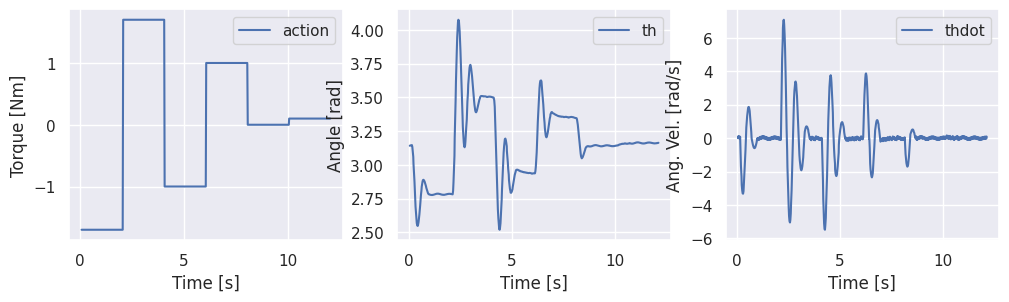

In [5]:
# @title Visualize the actions and sensor readings (as might be observed in a real-world system)
fig_data, axes = plt.subplots(1, 3, figsize=(12, 3))
axes[0].plot(record.nodes["agent"].steps.ts_end[:-1], record.nodes["agent"].steps.output.action, label="action")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Torque [Nm]")
axes[0].legend()

axes[1].plot(record.nodes["sensor"].steps.ts_end, record.nodes["sensor"].steps.output.th, label="th")
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("Angle [rad]")
axes[1].legend()

axes[2].plot(record.nodes["sensor"].steps.ts_end, record.nodes["sensor"].steps.output.thdot, label="thdot")
axes[2].set_xlabel("Time [s]")
axes[2].set_ylabel("Ang. Vel. [rad/s]")
axes[2].legend();

In [6]:
# @title Example fitting of a GMM to the delays (for the ones that can be observed in a real-world system)
# @markdown For simplicity, we only fit a GMM to the delays of the communication between the sensor and agent,
# @markdown and the computation delay of the agent's step method.
# @markdown Other delays could be fitted in the same way, e.g., the delays of the actuator.
from rexv2.gmm_estimator import GMMEstimator

# Fit GMM to communication delay between sensor and agent
delay_comm = record.nodes["agent"].inputs["sensor"].messages.delay
gmm_comm = GMMEstimator(delay_comm, "communication_delay")
gmm_comm.fit(num_steps=100, num_components=2, step_size=0.05, seed=0)
dist_comm = gmm_comm.get_dist()

# Fit GMM to computation delay of the agent's step method
delay_comp = record.nodes["agent"].steps.delay
gmm_comp = GMMEstimator(delay_comp, "computation_delay")
gmm_comp.fit(num_steps=100, num_components=2, step_size=0.05, seed=0)
dist_comp = gmm_comp.get_dist()

communication_delay | Time taken: 1.36 seconds.
computation_delay | Time taken: 1.18 seconds.


In [7]:
# @title Visualize the fitting of a GMM to the delays (for the ones that can be observed in a real-world system)
%matplotlib agg

# Plot GMMs
# with plt.ioff(): 
fig_gmm, axes = plt.subplots(1, 2, figsize=(8, 3));
gmm_comm.plot_hist(ax=axes[0], edgecolor=ecolor.communication, facecolor=fcolor.communication, plot_dist=True)
axes[0].set_title("Delay (sensor->agent)")
gmm_comp.plot_hist(ax=axes[1], edgecolor=ecolor.computation, facecolor=fcolor.computation, plot_dist=False)
axes[1].set_title("Delay (agent.step)")
for ax, dist in zip(axes, [dist_comm, dist_comp]):
    ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.3f'))
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.set_xlabel('delay (s)', fontsize=10)
    ax.set_ylabel('density', fontsize=10)
    ax.set_xlim([0, dist.quantile(0.99)])  # Limit the x-axis to the 99th percentile of the delay

# Animate training
ani = gmm_comp.animate_training(fig=fig_gmm, ax=axes[1], num_frames=50)
HTML(ani.to_html5_video())

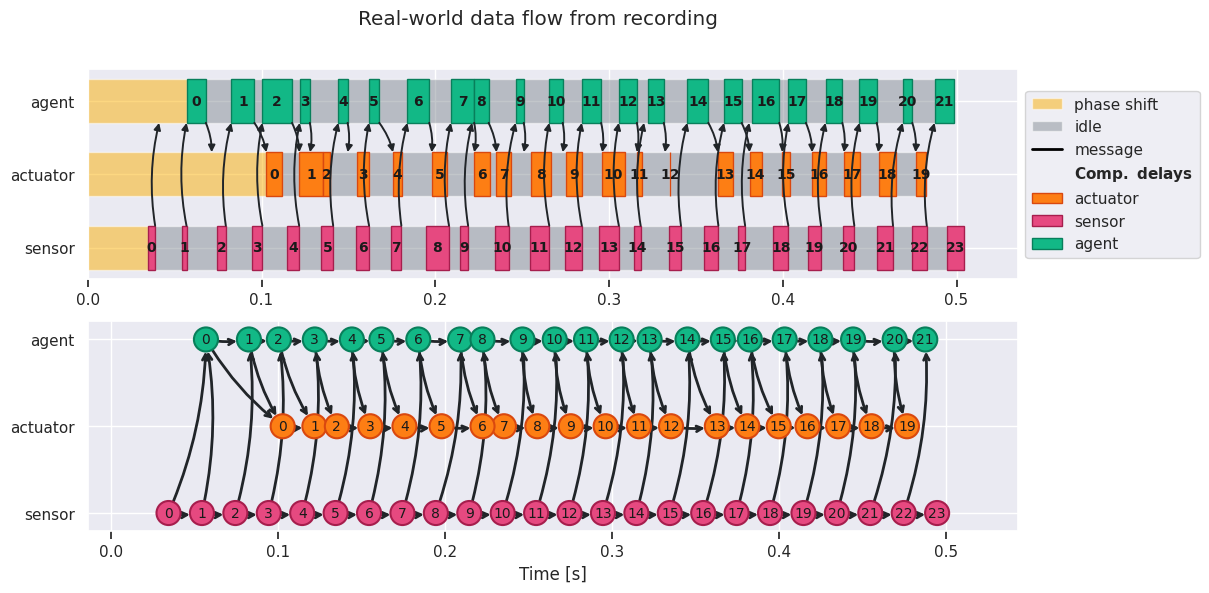

In [8]:
# @title Visualize the data flow as might be observed in a real-world system (as per the specified simulated delays)
# @markdown The top plot shows the data flow, showing how long each node takes to process the data and send it to the next node.
# @markdown The bottom plot shows a graph representation of the data flow, where we omit displaying the computation delays.
# @markdown Each vertex represents a step call of a node, and each edge represents the communication delay between two nodes.
# @markdown Edges between consecutive steps of the same node represent the transmission of the internal state of the node.
# @markdown Nodes start processing after an initial phase-shift, that is a result of the expected delays as specified when 
# @markdown defining the nodes and connections. The 'delay' argument specifies how much delay is expected.
plt.close(fig_gmm) # Close fig_gmm to prevent it from displaying in the next cell
%matplotlib inline

df = record.to_graph()
timing_mode = "arrival"  # "arrival" or "usage"
G = rutils.to_networkx_graph(df, nodes=nodes)
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
rutils.plot_graph(G, max_x=0.5, ax=axes[0], message_arrow_timing_mode=timing_mode,
                  edge_linewidth=1.4, arrowsize=10,
                  show_labels=True, height=0.6, label_loc="center")
supergraph.plot_graph(G, max_x=0.5, ax=axes[1])
fig.suptitle("Real-world data flow from recording")
axes[-1].set_xlabel("Time [s]");

In [9]:
# @title Build a simple ODE simulation environment that we are going to use to identify the hidden delays and parameters
# @markdown We will use the data collected from the "real" system to identify the delays and parameters of a simple ODE model
# @markdown We will use the identified communication delay between the sensor and agent,
# @markdown and the computation delay of the agent's step method to build a simple ODE model.

# Prepare the recorded data that we are going to use for system identification
outputs = {name: n.steps.output[None] for name, n in record.nodes.items()}

# By reinitializing the nodes via the `from_info` method, we can reuse the exact same configuration (rate, delay_dist, etc.).
# We can overwrite (e.g., delay_dist) or specify extra parameters (e.g., outputs) as keyword arguments.
# The info data is stored in the record, but can also be obtained from the nodes themselves with node.info.
from rexv2.pendulum.nodes import SimSensor, Agent, SimActuator, OdeWorld
actuator = SimActuator.from_info(record.nodes["actuator"].info, outputs=outputs["actuator"])  # Actuator data to replay the actions
sensor = SimSensor.from_info(record.nodes["sensor"].info, outputs=outputs["sensor"])  # Sensor data to calculate reconstruction error
agent = Agent.from_info(record.nodes["agent"].info, delay_dist=dist_comp)
nodes_sim = dict(sensor=sensor, agent=agent, actuator=actuator)

# Connect nodes according to real-world system
[n.connect_from_info(record.nodes[name].info.inputs, nodes_sim) for name, n in nodes_sim.items()]

# Create the world node that is going to simulate the ODE system
world = OdeWorld.from_info(nodes["world"].info)  # Initialize OdeWorld with the same parameters (rate, etc.) as the brax world

# Next, we connect the world node to the nodes that interface with hardware (actuator and sensor)
# We specify trainable delays to represent sensor and actuator delays that we want to identify in addition to the ode parameters
world.connect(actuator, window=1, name="actuator", skip=True,  # Sends the action to the ODE world (skip=True to resolve circular dependency)
              # Trainable delay to represent the actuator delay
              # delay, min, and max are seconds, interp in ["zoh", "linear"]
              delay_dist=TrainableDist.create(delay=0.0, min=0, max=0.3, interp="linear"))
sensor.connect(world, window=1, name="world",  # Communicate the ODE world's state to the sensor node
               # Trainable delay to represent the sensor delay
               # delay, min, and max are seconds, interp in ["zoh", "linear"]
               delay_dist=TrainableDist.create(delay=0.0, min=0, max=0.3, interp="linear"))
nodes_sim["world"] = world  # Add the world node to the nodes

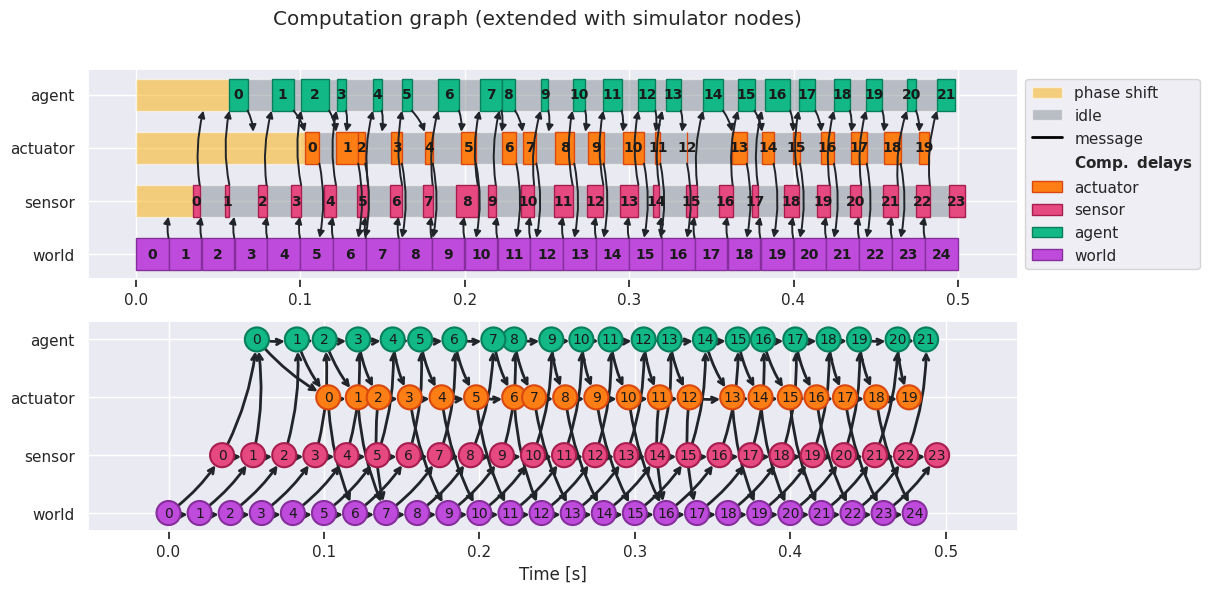

In [10]:
# @title Build the computational graph we are going to use to identify the hidden delays and parameters
# @markdown World vertices are added to the data flow graph which represent simulator steps.
# @markdown The edges between the world vertices and the other nodes are added according to the min/max delays
# @markdown that we specified in the trainable delay distributions.
rng, rng_aug = jax.random.split(rng)
cg = rexv2.artificial.augment_graphs(df, nodes_sim, rng_aug)
timing_mode = "arrival"  # "arrival" or "usage"
G = rutils.to_networkx_graph(cg, nodes=nodes)
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
rutils.plot_graph(G, max_x=0.5, ax=axes[0], message_arrow_timing_mode=timing_mode,
                  edge_linewidth=1.4, arrowsize=10,
                  show_labels=True, height=0.6, label_loc="center")
supergraph.plot_graph(G, max_x=0.5, ax=axes[1])
fig.suptitle(f"Computation graph (extended with simulator nodes)")
axes[-1].set_xlabel("Time [s]");

In [11]:
# @title First, we define the subset of trainable parameters that we want to identify (delays, ode parameters)
# @markdown The training loop will go as follows:
# @markdown 1. For each trainable parameter, we sample a normalized value from a search distribution.
# @markdown 2. We denormalize the sampled value based on the min/max values of each parameter.
# @markdown 3. We extend the trainable parameters with the non-trainable parameters to get the full parameter structure.
# @markdown 4. We run the simulation with the extended parameters and collect the reconstruction error.
# @markdown 5. We update the search distribution based on the reconstruction error.
# @markdown 6. We repeat the process until convergence.

# Initialize a graph that can be compiled and parallelized for system identification
# Note, we could choose to skip running the agent node for computational efficiency,
# as we know it does not affect the world node in this case, as we are replaying the actions in the actuator node.
graph_sim = rexv2.graph.Graph(nodes_sim, nodes_sim["agent"], cg)

# Get initial graph state (aggregate of all node states)
rng, rng_init = jax.random.split(rng)
gs_init = graph_sim.init(rng_init, order=("agent",))
gs_init_sim = gs_init

# Define the set of trainable parameters and the initial values
# We only want to optimize for a subset of the parameters, e.g., the delays and the parameters of the ODE system.
# Hence, we take all parameters, set them them to None (i.e., not trainable),
# and then set the ones we want to optimize to trainable values.
base_params = gs_init.params.unfreeze().copy()  # Get base structure for params
init_params = jax.tree_util.tree_map(lambda x: None, base_params)  # Set all parameters to None (i.e. not trainable)
init_params["world"] = init_params["world"].replace(J=0.0001,   # Inertia of the pendulum (trainable)
                                                    mass=0.05,  # Mass of the pendulum (trainable)
                                                    length=0.03,  # Length of the pendulum (trainable)
                                                    b=1.e-05,   # Damping of the pendulum (trainable)
                                                    K=0.02,     # Spring constant of the pendulum (trainable)
                                                    R=5.,          # DC-motor resistance of the pendulum (trainable)
                                                    c=0.0007)    # Coulomb friction of the pendulum (trainable)
init_params["sensor"] = init_params["sensor"].replace(sensor_delay=0.15)  # Sensor delay (trainable)
init_params["actuator"] = init_params["actuator"].replace(actuator_delay=0.15)  # actuator delay (trainable)
init_params["agent"] = init_params["agent"].replace(init_method="parametrized",  # Set to "parametrized" avoid random state initialization
                                                    parametrized=jnp.array([0.5*jnp.pi, 0.0])) # Initial state (trainable)

# Print the initial parameters
print("Initial parameters (None means not trainable):")
eqx.tree_pprint(init_params, short_arrays=False)

# It's also good practice to perform a search over normalized parameters, provided we are given a min and max for each parameter.
min_params, max_params = init_params.copy(), init_params.copy()  # Get base structure for min and max params
# Set the min and max for the ODE parameters
min_params["world"] = jax.tree_util.tree_map(lambda x: x*0.25, min_params["world"])  # Set the min for the ODE parameters
max_params["world"] = jax.tree_util.tree_map(lambda x: x*2.0, max_params["world"])  # Set the max for the ODE parameters
# Set the min and max for the delays
min_params["sensor"] = min_params["sensor"].replace(sensor_delay=0.0)  # Set the min for the sensor delay
max_params["sensor"] = max_params["sensor"].replace(sensor_delay=0.3)  # Set the max for the sensor delay
min_params["actuator"] = min_params["actuator"].replace(actuator_delay=0.0)  # Set the min for the actuator delay
max_params["actuator"] = max_params["actuator"].replace(actuator_delay=0.3)  # Set the max for the actuator delay
# Ensure agent's initial state has a non-zero range, as 0.5*0 = 0, and 1.5*0 = 0
# if max_params["agent"].parametrized is not None:  # todo: remove
min_params = eqx.tree_at(lambda _min: _min["agent"].parametrized, min_params, jnp.array([-jnp.pi, -0.2]))  # Set the min for the initial state
max_params = eqx.tree_at(lambda _max: _max["agent"].parametrized, max_params, jnp.array([jnp.pi, 0.2]))  # Set the max for the initial state

# Next, we define the transform that transforms the normalized candidate parameters to the full parameter structure
# First, we denormalize the parameters, then extend with the non-trainable parameters (e.g., max_speed of the ODE world)
denorm = base.Denormalize.init(min_params, max_params)  # Create a transform to denormalize a set of normalized parameters
extend = base.Extend.init(base_params, init_params)  # Create a transform to extend the trainable params with the non-trainable
denorm_extend = base.Chain.init(denorm, extend)

# Normalize the initial, min, and max parameters
norm_init_params = denorm.inv(init_params)  # Normalize the initial parameters
norm_min_params = denorm.inv(min_params)  # Normalize the min parameters
norm_max_params = denorm.inv(max_params)  # Normalize the max parameters

Growing supergraph: 100%|██████████| 601/601 [00:00<00:00, 1211.98it/s, 1/1 graphs, 2411/2411 matched (66.86% efficiency, 6 nodes (pre-filtered: 6 nodes))]


Initial parameters (None means not trainable):
{
  'actuator':
  ActuatorParams(actuator_delay=0.15),
  'agent':
  AgentParams(
    policy=None,
    num_act=4,
    num_obs=4,
    max_torque=None,
    init_method='parametrized',
    parametrized=Array([1.5707964, 0.       ], dtype=float32),
    max_th=None,
    max_thdot=None,
    gamma=None,
    tmax=None
  ),
  'sensor':
  SensorParams(sensor_delay=0.15),
  'world':
  OdeParams(
    max_speed=None,
    J=0.0001,
    mass=0.05,
    length=0.03,
    b=1e-05,
    K=0.02,
    R=5.0,
    c=0.0007,
    dt_substeps_min=0.01,
    dt=0.02
  )
}


In [12]:
# @title Define the loss function that we are going to use to identify the hidden delays and parameters

def get_loss(norm_params, transform, rng):
    # Transform normalized parameters to full parameter structure
    params = transform.apply(norm_params)  # := denorm_extend.apply(norm_params)

    # Initialize the graph state
    # By supplying the params, we override the params generated by every node's init_params method
    # This allows us to run the graph with the specified parameters
    gs_init = graph_sim.init(rng=rng, params=params, order=("agent",))

    # Rollout graph
    final_gs = graph_sim.rollout(gs_init, carry_only=True)

    # Get the reconstruction error
    loss_th = final_gs.state["sensor"].loss_th
    loss_thdot = final_gs.state["sensor"].loss_thdot
    loss = loss_th + loss_thdot
    return loss

# Get cost of initial guess
init_loss = get_loss(norm_init_params, denorm_extend, rng)  # Get the initial loss
print(f"Loss of initial guess: {init_loss}")  # Loss using the initial parameters

Loss of initial guess: 11933.826171875


In [13]:
# @title Initialize the evolutionary strategy solver for system identification
# @markdown We use the CMA-ES strategy to optimize the parameters
# @markdown We must initialize it with a normalized min and max parameter structure
import rexv2.evo as evo

# Initialize the solver
max_steps = 50  # Number of optimization steps
strategy_kwargs = dict(popsize=200, elite_ratio=0.1, sigma_init=0.4, mean_decay=0.)
solver = evo.EvoSolver.init(norm_min_params, norm_max_params, strategy="CMA_ES", strategy_kwargs=strategy_kwargs)
init_sol_state = solver.init_state(norm_init_params)  # Initialize the solver state

# Run the optimization
rng, rng_sol = jax.random.split(rng)
init_log_state = solver.init_logger(num_generations=max_steps)
with rutils.timer("evo | compile + optimize"):
    sol_state, log_state, losses = evo.evo(get_loss, solver, init_sol_state, denorm_extend, max_steps=max_steps, rng=rng_sol, verbose=True, logger=init_log_state)
norm_opt_params = solver.unflatten(sol_state.best_member)
opt_params = denorm_extend.apply(norm_opt_params)

# Print identified delays vs true delays
# Note that it's inherently not possible to distinguish between sensor and actuator delays, but we can estimate their sum.
# Hence, we compare the sum of the identified delays with the sum of the true delays.
# print(f"Sensor delay | true={sensor_delay:.3f}\u00B1{std_delay:.3f}, opt={opt_params['sensor'].sensor_delay:.3f}, init={init_params['sensor'].sensor_delay:.3f}")
# print(f"Actuator delay | true={actuator_delay:.3f}\u00B1{std_delay:.3f}, opt={opt_params['actuator'].actuator_delay:.3f}, init={init_params['actuator'].actuator_delay:.3f}")
print(f"Actuator+senor delay | "
      f"true={sensor_delay+actuator_delay:.3f}\u00B1{std_delay * 2:.3f}, "
      f"opt={opt_params['sensor'].sensor_delay+opt_params['actuator'].actuator_delay:.3f}, "
      f"init={init_params['sensor'].sensor_delay+init_params['actuator'].actuator_delay:.3f}")

def rollout(params, rng, carry_only: bool = True):
    # Initialize the graph state
    # By supplying the params, we override the params generated by every node's init_params method
    # This allows us to run the graph with the specified parameters
    gs_init = graph_sim.init(rng=rng, params=params, order=("agent",))

    # Rollout graph
    gs_rollout = graph_sim.rollout(gs_init, carry_only=carry_only)
    return gs_rollout

rng, rng_rollout = jax.random.split(rng)
init_rollout = rollout(extend.apply(init_params), rng_rollout, carry_only=False)
opt_rollout = rollout(opt_params, rng_rollout, carry_only=False)

ParameterReshaper: 11 parameters detected for optimization.
ParameterReshaper: 11 parameters detected for optimization.
step: 0 | min_loss: 1116.5584716796875 | mean_loss: 106809.28125 | max_loss: 568769.8125 | bestsofar_loss: 1116.5584716796875 | total_samples: 200
step: 1 | min_loss: 1233.85205078125 | mean_loss: 76688.9296875 | max_loss: 542534.5625 | bestsofar_loss: 1116.5584716796875 | total_samples: 400
step: 2 | min_loss: 534.4483642578125 | mean_loss: 35886.66015625 | max_loss: 560240.0625 | bestsofar_loss: 534.4483642578125 | total_samples: 600
step: 3 | min_loss: 405.5484924316406 | mean_loss: 28601.681640625 | max_loss: 516337.4375 | bestsofar_loss: 405.5484924316406 | total_samples: 800
step: 4 | min_loss: 84.00861358642578 | mean_loss: 31236.08984375 | max_loss: 450640.59375 | bestsofar_loss: 84.00861358642578 | total_samples: 1000
step: 5 | min_loss: 264.3010559082031 | mean_loss: 29374.494140625 | max_loss: 532563.375 | bestsofar_loss: 84.00861358642578 | total_samples: 

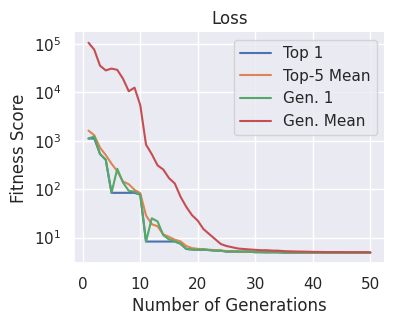

In [14]:
# @title Plot the loss
fig_loss, ax_loss = plt.subplots(1, 1, figsize=(4, 3))
log_state.plot("Loss", fig=fig_loss, ax=ax_loss)
ax_loss.set_yscale("log");

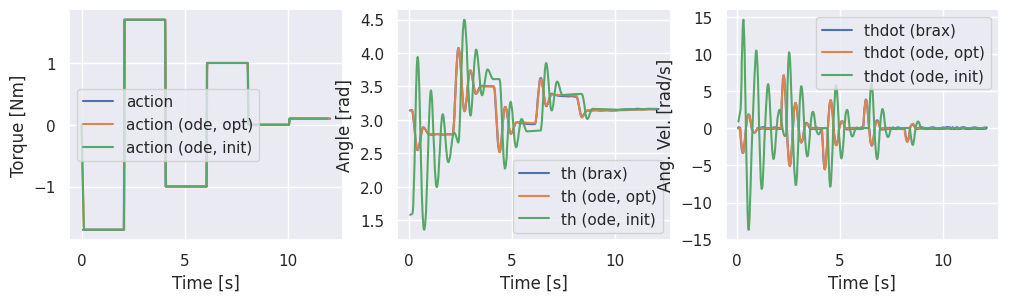

In [15]:
# @title Visualize the reconstructed sensor readings and the true sensor readings
# @markdown The reconstructed sensor readings are indistinguishable from the true sensor readings, which is a good sign.

# Rollout the optimized parameters
init_sensor = init_rollout.inputs["agent"]["sensor"].data[:, -1]
init_ts_sensor = init_rollout.inputs["agent"]["sensor"].ts_sent[:, -1]
init_actuator = init_rollout.inputs["world"]["actuator"].data[:, -1]
init_ts_actuator = init_rollout.inputs["world"]["actuator"].ts_sent[:, -1]

opt_sensor = opt_rollout.inputs["agent"]["sensor"].data[:, -1]
opt_ts_sensor = opt_rollout.inputs["agent"]["sensor"].ts_sent[:, -1]
opt_actuator = opt_rollout.inputs["world"]["actuator"].data[:, -1]
opt_ts_actuator = opt_rollout.inputs["world"]["actuator"].ts_sent[:, -1]

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes[0].plot(record.nodes["agent"].steps.ts_end[:-1], record.nodes["agent"].steps.output.action, label="action")
axes[0].plot(opt_ts_actuator, opt_actuator.action[:, 0], label="action (ode, opt)")
axes[0].plot(init_ts_actuator, init_actuator.action[:, 0], label="action (ode, init)")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Torque [Nm]")
axes[0].legend()

axes[1].plot(record.nodes["sensor"].steps.ts_end, record.nodes["sensor"].steps.output.th, label="th (brax)")
axes[1].plot(opt_ts_sensor, opt_sensor.th, label="th (ode, opt)")
axes[1].plot(init_ts_sensor, init_sensor.th, label="th (ode, init)")
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("Angle [rad]")
axes[1].legend()

axes[2].plot(record.nodes["sensor"].steps.ts_end, record.nodes["sensor"].steps.output.thdot, label="thdot (brax)")
axes[2].plot(opt_ts_sensor, opt_sensor.thdot, label="thdot (ode, opt)")
axes[2].plot(init_ts_sensor, init_sensor.thdot, label="thdot (ode, init)")
axes[2].set_xlabel("Time [s]")
axes[2].set_ylabel("Ang. Vel. [rad/s]")
axes[2].legend();

In [16]:
# @title Train a policy to swing up the pendulum using PPO on the identified system
# @markdown We use the identified system to train a policy to swing up the pendulum using PPO
# @markdown We train 5 policies in parallel and select the best one based on the mean return
# @markdown The success rate is defined as the percentage of steps where the pendulum is upright (cos(theta) > 0.95 and |theta_dot| < 0.5)
# Reinitialize a graph with nodes (that do not replay actions and calculate reconstruction error)
infos_sim = {name: n.info for name, n in nodes_sim.items()}
nodes_rl = {name: n.from_info(infos_sim[name]) for name, n in nodes_sim.items()}
[n.connect_from_info(infos_sim[name].inputs, nodes_rl) for name, n in nodes_rl.items()]
graph_rl = rexv2.graph.Graph(nodes_rl, nodes_rl["agent"], cg)

# Define the environment
from rexv2.pendulum.rl import SwingUpEnv, sweep_pmv2r1zf
env = SwingUpEnv(graph=graph_rl)

# Set RL params
rl_params = opt_params.copy()  # Get base structure for params
rl_params["agent"] = rl_params["agent"].replace(init_method="random")
env.set_params(rl_params)

# Initialize PPO config
# sweep_pmv2r1zf is a PPO hyperparameter sweep that was found to work well for the pendulum swing-up task
config = sweep_pmv2r1zf

# Train
import rexv2.ppo as ppo
rng, rng_train = jax.random.split(rng)
rngs_train = jax.random.split(rng_train, num=5)
train = functools.partial(ppo.train, env)
with rutils.timer("ppo | compile"):
    train_v = jax.vmap(train, in_axes=(None, 0))
    train_vjit = jax.jit(train_v)
    train_vjit = train_vjit.lower(config, rngs_train).compile()
with rutils.timer("ppo | train"):
    res = train_vjit(config, rngs_train)
    
# Get best policy (based on res.metrics["eval/mean_returns"])
best_idx = jnp.argmax(res.metrics["eval/mean_returns"][:, -1])
best_policy = res.policy[best_idx]
eval_params = rl_params.copy()
eval_params["agent"] = eval_params["agent"].replace(init_method="random", policy=best_policy)

Growing supergraph: 100%|██████████| 601/601 [00:00<00:00, 1241.75it/s, 1/1 graphs, 2411/2411 matched (66.86% efficiency, 6 nodes (pre-filtered: 6 nodes))]


[51881][MainThread               ][tracer              ][ppo | compile       ] Elapsed: 36.3227 sec
train_steps=249856 | eval_eps=20 | return=-826.0+-87.6 | length=147+-0.0 | approxkl=0.0032 | success_rate=0.02
train_steps=249856 | eval_eps=20 | return=-1041.8+-109.3 | length=147+-0.0 | approxkl=0.0035 | success_rate=0.00
train_steps=249856 | eval_eps=20 | return=-541.5+-46.1 | length=147+-0.0 | approxkl=0.0034 | success_rate=0.01
train_steps=249856 | eval_eps=20 | return=-431.4+-60.1 | length=147+-0.0 | approxkl=0.0035 | success_rate=0.01
train_steps=249856 | eval_eps=20 | return=-391.4+-67.4 | length=147+-0.0 | approxkl=0.0035 | success_rate=0.01
train_steps=499712 | eval_eps=20 | return=-439.4+-101.4 | length=147+-0.0 | approxkl=0.0031 | success_rate=0.06
train_steps=499712 | eval_eps=20 | return=-967.8+-116.4 | length=147+-0.0 | approxkl=0.0024 | success_rate=0.00
train_steps=499712 | eval_eps=20 | return=-432.1+-107.2 | length=147+-0.0 | approxkl=0.0032 | success_rate=0.04
train_s

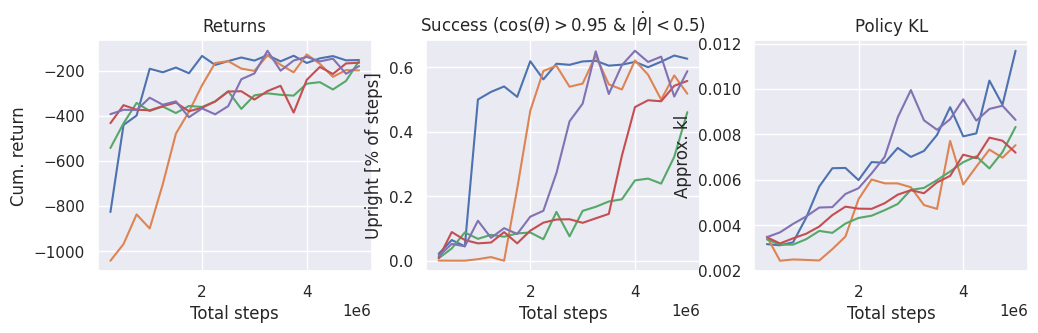

In [17]:
# @title Visualize the training progress of the PPO algorithm

fig_ppo, axes_ppo = plt.subplots(1, 3, figsize=(12, 3))
total_steps = res.metrics["train/total_steps"].transpose()
mean, std = res.metrics["eval/mean_returns"].transpose(), res.metrics["eval/std_returns"].transpose()
axes_ppo[0].plot(total_steps, mean, label="mean")
axes_ppo[0].set_title("Returns")
axes_ppo[0].set_xlabel("Total steps")
axes_ppo[0].set_ylabel("Cum. return")
mean = res.metrics["eval/success_rate"].transpose()
axes_ppo[1].plot(total_steps, mean, label="mean")
axes_ppo[1].set_title(r"Success ($\cos(\theta) > 0.95$ & $|\dot{\theta}| < 0.5$)")
axes_ppo[1].set_xlabel("Total steps")
axes_ppo[1].set_ylabel("Upright [% of steps]")
mean, std = res.metrics["train/mean_approxkl"].transpose(), res.metrics["train/std_approxkl"].transpose()
axes_ppo[2].plot(total_steps, mean, label="mean")
axes_ppo[2].set_title("Policy KL")
axes_ppo[2].set_xlabel("Total steps")
axes_ppo[2].set_ylabel("Approx. kl");

In [18]:
# @title Evaluate the learned policy on the simulated system
# @markdown We evaluate the learned policy in parallel on the simulated system
# @markdown We run 20,000 rollouts and calculate the success rate (i.e., the percentage of time the pendulum is upright and not moving)
num_rollouts = 20_000  # Lower if memory is an issue
max_steps = int(5*nodes_sim["agent"].rate)  # 5 seconds

# Check if we have a GPU
try:
    gpu = jax.devices("gpu")
except RuntimeError:
    num_rollouts = 100  # Lower if no GPU is available
    print("Warning: No GPU found, falling back to CPU. Speedups will be less pronounced. Lowering the number of rollouts to 100.")
    print("Hint: if you are using Google Colab, try to change the runtime to GPU: "
          "Runtime -> Change runtime type -> Hardware accelerator -> GPU.")

def rollout_fn(rng):
    # Initialize graph state
    _gs = graph_rl.init(rng, params=eval_params, order=("agent",))
    # Make sure to record the params, state, and output
    _gs = graph_rl.init_record(_gs, params=False, state=True, output=False)
    # Run the graph for a fixed number of steps
    _gs_rollout = graph_rl.rollout(_gs, carry_only=True, max_steps=max_steps)
    # This returns a record that may only be partially filled.
    record = _gs_rollout.aux["record"]
    is_filled = record.nodes["world"].steps.seq >= 0  # Unfilled steps are marked with -1
    return is_filled, record.nodes["world"].steps.state

rng, rng_rollout = jax.random.split(rng)
rngs_rollout = jax.random.split(rng_rollout, num=num_rollouts)
t_jit = rutils.timer(f"Vectorized evaluation of {num_rollouts} rollouts | compile", log_level=100)  # Makes them available outside the context manager
with t_jit:
    rollout_fn_jv = jax.jit(jax.vmap(rollout_fn))
    rollout_fn_jv = rollout_fn_jv.lower(rngs_rollout)
    rollout_fn_jv = rollout_fn_jv.compile()
t_run = rutils.timer(f"Vectorized evaluation of {num_rollouts} rollouts | rollouts", log_level=100)
with t_run:
    is_filled, final_states = rollout_fn_jv(rngs_rollout)
    final_states.th.block_until_ready()

# Only keep the filled rollouts (we did not run the full duration of the computation graph)
final_states = final_states[is_filled]

# Calculate success rate
thr_upright = 0.95  # Cosine of the angle threshold
thr_static = 0.5  # Angular velocity threshold
cos_th = jnp.cos(final_states.th)
thdot = final_states.thdot
is_upright = cos_th > thr_upright
is_static = jnp.abs(thdot) < thr_static
is_valid = jnp.logical_and(is_upright, is_static)
success_rate = is_valid.sum() / is_valid.size
print(f"sim. eval | Success rate: {success_rate:.2f}")
print(f"sim. eval | fps: {(num_rollouts * max_steps) / t_run.duration / 1e6:.0f} Million steps/s | compile: {t_jit.duration:.2f} s | run: {t_run.duration:.2f} s")

[51881][MainThread               ][tracer              ][Vectorized evaluation of 20000 rollouts | compile] Elapsed: 6.3779 sec
[51881][MainThread               ][tracer              ][Vectorized evaluation of 20000 rollouts | rollouts] Elapsed: 0.2004 sec
sim. eval | Success rate: 0.77
sim. eval | fps: 25 Million steps/s | compile: 6.38 s | run: 0.20 s


In [19]:
# @title Evaluate the learned policy on the "real" brax system
# @markdown We evaluate the learned policy on the "real" brax system

@jax.jit
def get_action(step_state: base.StepState):
    obs = eval_params["agent"].get_observation(step_state)
    action = eval_params["agent"].policy.get_action(obs)
    output = eval_params["agent"].to_output(action)  # Convert the action to an output message
    new_ss = step_state.replace(state=eval_params["agent"].update_state(step_state, action))
    return new_ss, output

# Run for one episode
gs, ss = graph.reset(gs_init_real)  # Reset the graph to the initial state (returns the gs and the step state of the agent)
for i in tqdm.tqdm(range(max_steps), desc="brax | evaluate policy"):
    new_ss, output = get_action(ss)
    gs, ss = graph.step(gs, new_ss, output)  # Step the graph with the agent's output
graph.stop()  # Stops all nodes that were running asynchronously in the background
# Get the record
eval_record = graph.get_record()  # Get the record of the graph
eval_real_rollout = eval_record.nodes["world"].steps.state
# Filter out the world node, as it would not be available in a real-world system
eval_record = eval_record.filter(nodes_real)

brax | evaluate policy: 100%|██████████| 250/250 [00:01<00:00, 201.35it/s]


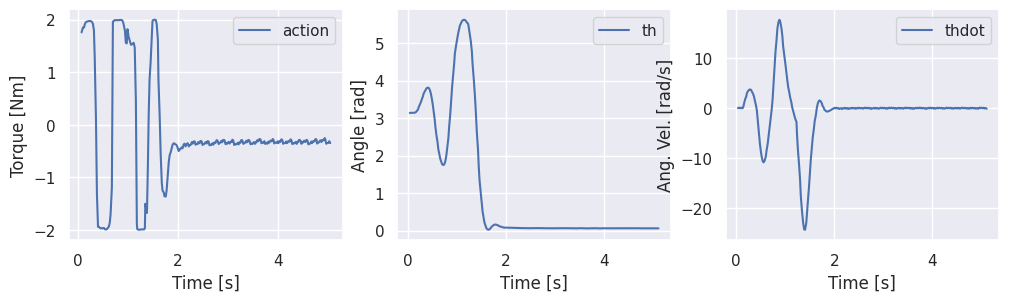

In [20]:
# @title Visualize the actions and sensor readings (as might be observed in a real-world system)
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes[0].plot(eval_record.nodes["agent"].steps.ts_end[:-1], eval_record.nodes["agent"].steps.output.action, label="action")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Torque [Nm]")
axes[0].legend()

axes[1].plot(eval_record.nodes["sensor"].steps.ts_end, eval_record.nodes["sensor"].steps.output.th, label="th")
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("Angle [rad]")
axes[1].legend()

axes[2].plot(eval_record.nodes["sensor"].steps.ts_end, eval_record.nodes["sensor"].steps.output.thdot, label="thdot")
axes[2].set_xlabel("Time [s]")
axes[2].set_ylabel("Ang. Vel. [rad/s]")
axes[2].legend();

In [24]:
# @title Visualize the rollout
# Html visualization may not work properly, if it's already rendering somewhere else.
# In such cases, comment-out all but one HTML(pendulum.render(rollout))
from rexv2.pendulum.nodes import render
HTML(render(eval_real_rollout, dt=float(1/world.rate))) 